In [1]:
from functions import *  #this allows the use of all the functions as if they were defined inside this file

This part is to check the settings.ini file and its parameters.

In [2]:
f = open('settings.ini')
settings = json.load(f)
 
for i in settings:
    print(i, end=': ')
    print(settings[i])
 
f.close()

fSampling: 10000000.0
quantizationBits: 16
scenarioDuration: 5.05
SV_PRN_ID: 1
CRCpolynomial: A23DCB
SYNCpattern: 0101100000
TAILpattern: 000000
SVIDlength: 6
MIDlength: 4
MBODYlength_TX: 80
MBODYlength_ACK: 30
CRClength: 24
nPRN_x_Symbol: 1
nChip_x_PRN: 4092
chipRate: 1023000.0
maxDoppler: 100000.0


The N_ACK.csv file is coming from the user receiver, it contains the message ID and if that message needs to be ACK or NACK

In [3]:
f = open('N_ACK.csv')
csv_file = csv.reader(f)
N_ACK = []
for row in csv_file:
        N_ACK.append(row)


for i in range(len(N_ACK)-1):
    if(N_ACK[i+1][1]=='1'):
        msg=createMessageACK(settings['SYNCpattern'],settings['SV_PRN_ID'],int(N_ACK[i+1][0]))
    if(N_ACK[i+1][1]=='0'):
        msg=createMessageNACK(settings['SYNCpattern'],settings['SV_PRN_ID'],int(N_ACK[i+1][0]))
    print(msg)

bitarray('01011000000000010000111111111111111000000000000000101011100011010101100011000000')
bitarray('01011000000000010001111111111111111000000000000000101011111100000101010001000000')
bitarray('01011000000000010010111111111111111000000000000000010101110110011110111101000000')
bitarray('01011000000000010011000000000000000111111111111111000111011001101110010101000000')
bitarray('01011000000000010100111111111111111000000000000000001110001101101100000111000000')
bitarray('01011000000000010101000000000000000111111111111111011100100010011100101111000000')
bitarray('01011000000000010110111111111111111000000000000000011100010100110000010111000000')
bitarray('01011000000000010111111111111111111000000000000000011100001011100000100101000000')
bitarray('01011000000000011000111111111111111000000000000000000001111000001010101101000000')
bitarray('01011000000000011001000000000000000111111111111111001000101111110010111001000000')


This part plots the origina orbital data regarding the Doppler shift, and also che interpolated Doppler shift from the function GetDopplerShift,
wich returns the interpolated Doppler shift at arbitrary sampling period, number of samples and starting time.

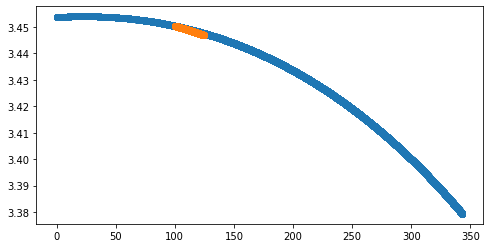

In [5]:
orbitalData = pd.read_csv('OrbitalDATA.txt', delim_whitespace=True)

dopplerFreqSamples = orbitalData['DopplerShift[Hz]'].dropna().to_numpy()
originalSamplingPeriod = 0.01
interpSamplingPeriod = 2.44E-6
StartTime = 100
numInterpSamples=10000000 # with this value it might take 10/30 seconds

interpDopplerShift=GetDopplerShift(dopplerFreqSamples, originalSamplingPeriod, StartTime, numInterpSamples, interpSamplingPeriod)

SampleTime = (np.asarray(range(0,len(dopplerFreqSamples))))*originalSamplingPeriod
InterpSampleTime = (np.asarray(range(0,numInterpSamples)))*interpSamplingPeriod
InterpSampleTime = np.asarray([i+StartTime for i in InterpSampleTime])

plt.figure(figsize=(8, 4))
plt.scatter(SampleTime, dopplerFreqSamples)
plt.scatter(InterpSampleTime, interpDopplerShift)